In [1]:
import os
import sys
import glob
import random
import itertools
from pathlib import Path
from tqdm import tqdm
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import cv2
from PIL import Image
from PIL import ImageFont
from PIL import ImageDraw
from IPython.display import SVG
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
import xml.etree.ElementTree as ET
from xml.etree.ElementTree import Element, ElementTree
import keras
import tensorflow as tf
from tensorflow.keras.datasets import mnist,cifar10
from tensorflow.keras.preprocessing.image import load_img,img_to_array,ImageDataGenerator
from tensorflow.keras.applications import NASNetMobile
from tensorflow.keras.models import Model,Sequential,load_model
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, Conv2D,GlobalAveragePooling2D
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.utils import to_categorical,plot_model
from tensorflow.keras.losses import categorical_crossentropy,binary_crossentropy
from tensorflow.keras.callbacks import Callback
from tensorflow.python.client import device_lib
import matplotlib.pyplot as plt

# 한글폰트 인식을 위해 설치해줍니다.

plt.rc('font', family='NanumGothic')
print(plt.rcParams['font.family'])

Using TensorFlow backend.
/home/intel/test/test2/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/intel/test/test2/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/intel/test/test2/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/intel/test/test2/lib/python3.6/site-packages/tenso

['NanumGothic']


/home/intel/test/test2/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/intel/test/test2/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/intel/test/test2/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/intel/test/test2/lib/python3.6/site-packages/tensorboar

In [2]:
# 우리가 분류할 17개의 클래스

CLASSES = [ 'airplane', 'bird', 'boat', 'bottle', 'car','cat', 'dog', 'drone', 'hamburger', 'horse', 'logo', 'minions', 'paper', 'person', 'rock', 'scissors', 'train']

# 학습에 필요한 상수들을 정의 합니다. 

IMG_SHAPE = (224, 224, 3)
IMAGE_BASE_PATH = './data/'

findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans.


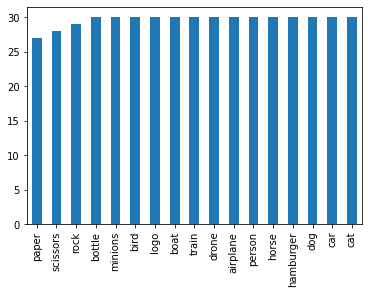

In [3]:
# 우리가 모델 훈련에 사용할 데이터 내용 입니다.

class_list = []
num_list = []

train_path = IMAGE_BASE_PATH + 'train/'
for folder in os.listdir(train_path):
    folder_size = len(os.listdir(train_path+folder))
#    print('{:<15} : {}'.format(folder,folder_size))
    class_list.append(folder)
    num_list.append(folder_size)
    
voc_s = pd.Series(num_list,index=class_list)
voc_s.sort_values().plot(kind='bar')
plt.show()

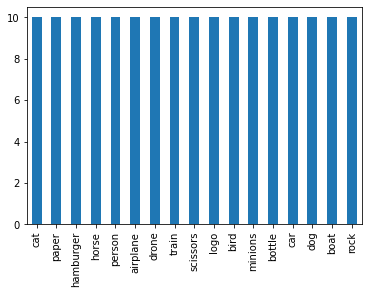

In [4]:
# 우리가 모델 훈련 검증에 사용할 데이터 내용 입니다.

class_list = []
num_list = []

valid_path = IMAGE_BASE_PATH + 'valid/'
for folder in os.listdir(valid_path):
    folder_size = len(os.listdir(valid_path+folder))
#     print('{:<15} : {}'.format(folder,folder_size))
    class_list.append(folder)
    num_list.append(folder_size)
    
voc_s = pd.Series(num_list,index=class_list)
voc_s.sort_values().plot(kind='bar')
plt.show()

In [5]:
# base model 의 input shape, 그리고  trainable 을 false 로 합니다. 

base_model = NASNetMobile(input_shape=(224,224,3),
                         include_top=False,
                         weights='imagenet')
base_model.trainable = False

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [6]:
# transfer learning에서 마지막 3개 block 을 사용하여 모델을 트레이닝 합니다. 

set_trainable = False
for layer in tqdm(base_model.layers):
    if layer.name in ['separable_conv_1_normal_left1_11', 'separable_conv_2_normal_left1_11', 'separable_conv_1_normal_left1_12', 'separable_conv_2_normal_left1_12']:
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

100%|██████████| 769/769 [00:00<00:00, 48807.14it/s]


In [7]:
# 레이어 구성을 살펴 봅니다. 

layers = [(layer, layer.name, layer.trainable) for layer in base_model.layers]

pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable']) 

,Layer Type,Layer Name,Layer Trainable
0,<tensorflow.python.keras.engine.input_layer.In...,input_1,False
1,<tensorflow.python.keras.layers.convolutional....,stem_conv1,False
2,<tensorflow.python.keras.layers.normalization....,stem_bn1,False
3,<tensorflow.python.keras.layers.core.Activatio...,activation,False
4,<tensorflow.python.keras.layers.convolutional....,reduction_conv_1_stem_1,False
...,...,...,...
764,<tensorflow.python.keras.layers.merge.Add obje...,normal_add_3_12,True
765,<tensorflow.python.keras.layers.merge.Add obje...,normal_add_4_12,True
766,<tensorflow.python.keras.layers.merge.Add obje...,normal_add_5_12,True
767,<tensorflow.python.keras.layers.merge.Concaten...,normal_concat_12,True


In [8]:
# 모델 만들기, 기존 모델의 weight 값을 사용하고 pooling 과 activation 함수를 추가 합니다. 

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(512,activation='relu'),
    Dense(64,activation='relu'),
    Dense(len(CLASSES), activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
NASNet (Model)               (None, 7, 7, 1056)        4269716   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1056)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               541184    
_________________________________________________________________
dense_1 (Dense)              (None, 64)                32832     
_________________________________________________________________
dense_2 (Dense)              (None, 17)                1105      
Total params: 4,844,837
Trainable params: 575,121
Non-trainable params: 4,269,716
_________________________________________________________________


In [9]:
model.compile(loss=categorical_crossentropy, 
              optimizer=Adam(learning_rate=0.0001), # transfer learning 여기서 학습률을 더 작게 
              metrics=['acc'])

In [10]:
# 트레인 데이터 augmentation 의로 데이터를 증가 시킴니다.  

train_datagen = ImageDataGenerator(rescale=1./255,
                                    rotation_range=30,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    shear_range=0.2,
                                    zoom_range=[0.8, 1.0],
                                    brightness_range=[0.9,1.0],
                                    horizontal_flip=True,
                                   )

train_set = train_datagen.flow_from_directory(IMAGE_BASE_PATH + 'train/',
                                              target_size=(224, 224),
                                              batch_size=16,
                                              shuffle=True,
                                              class_mode='categorical')

Found 503 images belonging to 17 classes.


In [11]:
# 학습중에 validation에 사용할 데이터셋 입니다.  

valid_datagen = ImageDataGenerator(rescale=1./255)

valid_set = valid_datagen.flow_from_directory(IMAGE_BASE_PATH + 'valid/',
                                            target_size=(224, 224),
                                            batch_size=16,
                                            shuffle=True,
                                            class_mode='categorical')

Found 170 images belonging to 17 classes.


In [ ]:
# 모델 트레이닝 입니다. 

history = model.fit_generator(train_set,
                              steps_per_epoch=train_set.n // train_set.batch_size,
                              epochs=50,
                              validation_data=valid_set,
                              validation_steps=valid_set.n // valid_set.batch_size,
#                              use_multiprocessing=True,
                              )

Epoch 1/50
31/31 [==============================] - 31s 989ms/step - loss: 2.7316 - acc: 0.1437 - val_loss: 2.4425 - val_acc: 0.4125
Epoch 2/50
31/31 [==============================] - 25s 795ms/step - loss: 2.2548 - acc: 0.4764 - val_loss: 1.9574 - val_acc: 0.6000
Epoch 3/50
31/31 [==============================] - 25s 797ms/step - loss: 1.7411 - acc: 0.6858 - val_loss: 1.4870 - val_acc: 0.7000
Epoch 4/50
15/31 [=============>................] - ETA: 10s - loss: 1.3829 - acc: 0.7417

In [20]:
model.save('./bin/NASNetMobile.h5')

In [ ]:
# 트레인 데이터와 테스트 데이터 셋으로 loss 와 accuracy 측정합니다.  

train_loss, train_acc = model.evaluate_generator(train_set)
print('Train Loss : {}'.format(train_loss))
print('Train Accuracy : {}'.format(train_acc))

valid_loss, valid_acc = model.evaluate_generator(valid_set)
print('Valid Loss : {}'.format(valid_loss))
print('Valid Accuracy : {}'.format(valid_acc))

In [ ]:
# loss 측정값의 시각화 입니다.  

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1,len(loss)+1)

plt.plot(epochs,loss,label='Training Loss')
plt.plot(epochs,val_loss,label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
# accuracy 측정값의 시각화 입니다.  

acc = history.history['acc']
val_acc = history.history['val_acc']
epochs = range(1,len(loss)+1)
plt.plot(epochs,acc,label='Training Accuarcy')
plt.plot(epochs,val_acc,label='Validation Accuarcy')
plt.title('Training and Validation Accuarcy')
plt.xlabel('Epochs')
plt.ylabel('Accuarcy')
plt.legend()

plt.show()

In [ ]:
# 추론하기 위한 작업입니다. 모델 설정, 입력 데이터 전처리.

def predict_test_img(path):
    img = cv2.imread(path) 
    
    model = load_model('./drive/My Drive/bin/NASNetMobile_15_class25.h5')
    
    print('Original Shape : ',img.shape)
    
    img = cv2.resize(img, (224,224), fx=0.5, fy=0.5, interpolation=cv2.INTER_AREA)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img / 255
    print('Resized Shape : ',img.shape)
    plt.imshow(img)
    plt.show()
    
    ans = model.predict_classes(np.expand_dims(img,axis=0))
    with open('./drive/My Drive/bin/class20.pickle','rb') as f:
        class20 = pickle.load(f)
    print('Predict : {}'.format(class20[ans[0]]))
    
    
    predicted_result = model.predict(np.expand_dims(img,axis=0))

    pd.DataFrame(predicted_result,columns=class20.values()).iloc[0].plot(kind='bar')
    plt.show()

Original Shape :  (500, 500, 3)
Resized Shape :  (224, 224, 3)


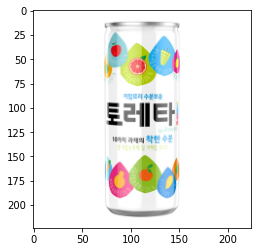

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
Predict : can


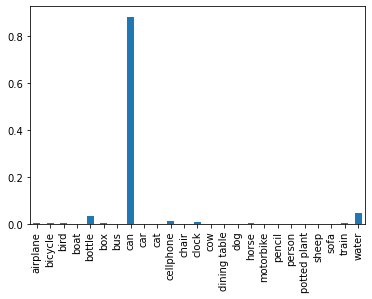

In [ ]:
# 기존에 사용되지 않았던 임의 데이터를 추론 하기

predict_test_img('./drive/My Drive/img/can.jpg')

Original Shape :  (350, 350, 3)
Resized Shape :  (224, 224, 3)


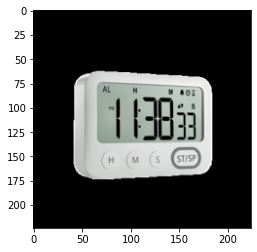

Predict : clock


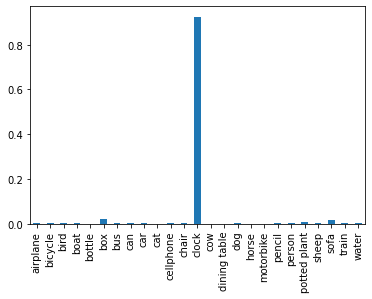

In [ ]:
predict_test_img('./drive/My Drive/img/clock.jpg')

Original Shape :  (224, 224, 3)
Resized Shape :  (224, 224, 3)


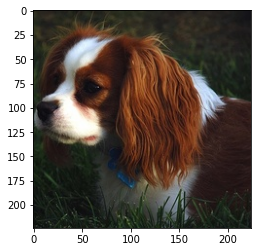

Predict : dog


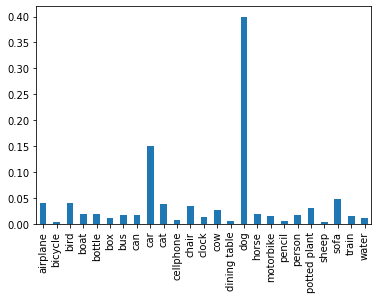

In [ ]:
predict_test_img('./drive/My Drive/img/dog.jpg')